In [1]:
import os
import copy
import pickle
import sympy
import dowhy
import functools
import itertools
import logging
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from random import choice
from error_injection import MissingValueError
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from scipy.optimize import minimize as scipy_min
from scipy.spatial import ConvexHull
from scipy.optimize import minimize, Bounds, linprog
from sympy import Symbol as sb
from sympy import lambdify
from tqdm.notebook import trange, tqdm
from dowhy import CausalModel
from dowhy import causal_estimators
import dowhy.datasets
from IPython.display import display, clear_output
from sklearn.preprocessing import StandardScaler

# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}
logging.config.dictConfig(DEFAULT_LOGGING)
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [2]:
# ignore all the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [4]:
X = df.drop(columns='target')
y = df['target']
#X = df.drop(columns='CO(GT)')
#y = df['CO(GT)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
#Useful functions
symbol_id = -1
def create_symbol(suffix=''):
    global symbol_id
    symbol_id += 1
    name = f'e{symbol_id}_{suffix}' if suffix else f'e{symbol_id}'
    return sympy.Symbol(name=name)


scaler_symbols = set([sb(f'k{i}') for i in range(X_train.shape[1]+1)])
linearization_dict = dict()
reverse_linearization_dict = dict()

In [6]:
def inject_ranges(X, y, uncertain_attr, uncertain_num, uncertain_radius_pct=None, 
                  uncertain_radius=None, seed=42):
    global symbol_id
    symbol_id = -1
    
    X_extended = np.append(np.ones((len(X), 1)), X, axis=1)
    ss = StandardScaler()
    X_extended[:, 1:] = ss.fit_transform(X_extended[:, 1:])
    X_extended_symb = sympy.Matrix(X_extended)
    
    if not(uncertain_attr=='y'):
        uncertain_attr_idx = X.columns.to_list().index(uncertain_attr) + 1
        if not(uncertain_radius):
            uncertain_radius = uncertain_radius_pct*(np.max(X_extended[:, uncertain_attr_idx])-\
                                                     np.min(X_extended[:, uncertain_attr_idx]))
    else:
        if not(uncertain_radius):
            uncertain_radius = uncertain_radius_pct*(y_train.max()-y_train.min())[0]
    
    np.random.seed(seed)
    uncertain_indices = np.random.choice(range(len(y)), uncertain_num, replace=False)
    y_symb = sympy.Matrix(y)
    symbols_in_data = set()
    #print(uncertain_indices)
    for uncertain_idx in uncertain_indices:
        new_symb = create_symbol()
        symbols_in_data.add(new_symb)
        if uncertain_attr=='y':
            y_symb[uncertain_idx] = y_symb[uncertain_idx] + uncertain_radius*new_symb
        else:
            X_extended_symb[uncertain_idx, uncertain_attr_idx] = X_extended_symb[uncertain_idx, uncertain_attr_idx] + uncertain_radius*new_symb
    return X_extended_symb, y_symb, symbols_in_data, ss

# if interval=True, use interval arithmetic, otherwise use zonotopes
def compute_robustness_ratio_label_error(X_train, y_train, X_test, y_test, robustness_radius,
                                         uncertain_num, uncertain_radius=None, 
                                         lr=0.1, seed=42, interval=True):
    X, y, symbols_in_data, ss = inject_ranges(X=X_train, y=y_train, uncertain_attr='y', 
                                              uncertain_num=uncertain_num, uncertain_radius=uncertain_radius, 
                                              uncertain_radius_pct=None, seed=seed)
    
    assert len(X.free_symbols)==0
    # closed-form
    param = (X.T*X).inv()*X.T*y
    
    if interval:
        # make param intervals
        for d in range(len(param)):
            expr = param[d]
            if not(expr.free_symbols):
                continue
            else:
                constant_part = 0
                interval_radius = 0
                for arg in expr.args:
                    if arg.free_symbols:
                        interval_radius += abs(arg.args[0])
                    else:
                        assert constant_part == 0
                        constant_part = arg
                param[d] = constant_part + create_symbol()*interval_radius
    
    test_preds = sympy.Matrix(np.append(np.ones((len(X_test), 1)), ss.transform(X_test), axis=1))*param
    robustness_ls = []
    for pred in test_preds:
        pred_range_radius = 0
        for arg in pred.args:
            if arg.free_symbols:
                pred_range_radius += abs(arg.args[0])
        if pred_range_radius <= robustness_radius:
            robustness_ls.append(1)
        else:
            robustness_ls.append(0)
    
#     print(param)
    return np.mean(robustness_ls)

In [7]:
# Running results with parameter adjustments on Zonotope
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num, 
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
robustness_dicts

[{'uncertain_radius': [0.05, 0.1, 0.15, 0.2, 0.25],
  'uncertain_radius_ratios': [0.05, 0.1, 0.15, 0.2, 0.25],
  0.01: [1.0, 1.0, 1.0, 1.0, 1.0],
  0.02: [1.0, 1.0, 1.0, 1.0, 1.0],
  0.03: [1.0, 1.0, 1.0, 1.0, 1.0],
  0.04: [1.0, 1.0, 1.0, 1.0, 1.0],
  0.05: [1.0, 1.0, 1.0, 1.0, 1.0],
  0.06: [1.0, 1.0, 1.0, 1.0, 1.0],
  0.07: [1.0, 1.0, 1.0, 1.0, 1.0],
  0.08: [1.0, 1.0, 1.0, 1.0, 1.0],
  0.09: [1.0, 1.0, 1.0, 1.0, 1.0],
  0.1: [1.0, 1.0, 1.0, 1.0, 1.0]},
 {'uncertain_radius': [0.05, 0.1, 0.15, 0.2, 0.25],
  'uncertain_radius_ratios': [0.05, 0.1, 0.15, 0.2, 0.25],
  0.01: [1.0, 1.0, 1.0, 1.0, 1.0],
  0.02: [1.0, 1.0, 1.0, 1.0, 1.0],
  0.03: [1.0, 1.0, 1.0, 1.0, 1.0],
  0.04: [1.0, 1.0, 1.0, 1.0, 1.0],
  0.05: [1.0, 1.0, 1.0, 1.0, 1.0],
  0.06: [1.0, 1.0, 1.0, 1.0, 1.0],
  0.07: [1.0, 1.0, 1.0, 1.0, 1.0],
  0.08: [1.0, 1.0, 1.0, 1.0, 1.0],
  0.09: [1.0, 1.0, 1.0, 1.0, 1.0],
  0.1: [1.0, 1.0, 1.0, 1.0, 1.0]},
 {'uncertain_radius': [0.05, 0.1, 0.15, 0.2, 0.25],
  'uncertain_radius_ratios

In [9]:
robustness_interval_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_interval_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_interval_mean)**2 for i in range(5)])/5).apply(np.sqrt)

In [10]:
robustness_interval_mean

,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [11]:
# Running results with parameter adjustments on Meyer
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num, 
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [12]:
robustness_zonotope_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_zonotope_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_zonotope_mean)**2 for i in range(5)])/5).apply(np.sqrt)
robustness_zonotope_mean

,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1
0,1.0,1.000000,1.000000,1.000000,1.000000,0.998246,0.996491,0.989474,0.978947,0.942105
1,1.0,1.000000,1.000000,0.984211,0.961404,0.912281,0.885965,0.845614,0.801754,0.747368
2,1.0,0.998246,0.982456,0.919298,0.868421,0.792982,0.735088,0.647368,0.570175,0.459649
3,1.0,0.991228,0.943860,0.849123,0.750877,0.652632,0.547368,0.442105,0.364912,0.296491
4,1.0,0.977193,0.891228,0.763158,0.622807,0.489474,0.382456,0.307018,0.249123,0.184211


In [13]:
robustness_zonotope_std

,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1
0,0.0,0.000000,0.000000,0.000000,0.000000,0.003509,0.004297,0.003509,0.016270,0.010526
1,0.0,0.000000,0.000000,0.019536,0.030689,0.028828,0.028828,0.030689,0.027516,0.023142
2,0.0,0.003509,0.022874,0.031579,0.053502,0.068981,0.050360,0.059339,0.047724,0.035350
3,0.0,0.013589,0.037050,0.056957,0.075377,0.110902,0.072463,0.046284,0.034019,0.012892
4,0.0,0.028613,0.052807,0.075866,0.109421,0.106340,0.050726,0.041885,0.034912,0.020003


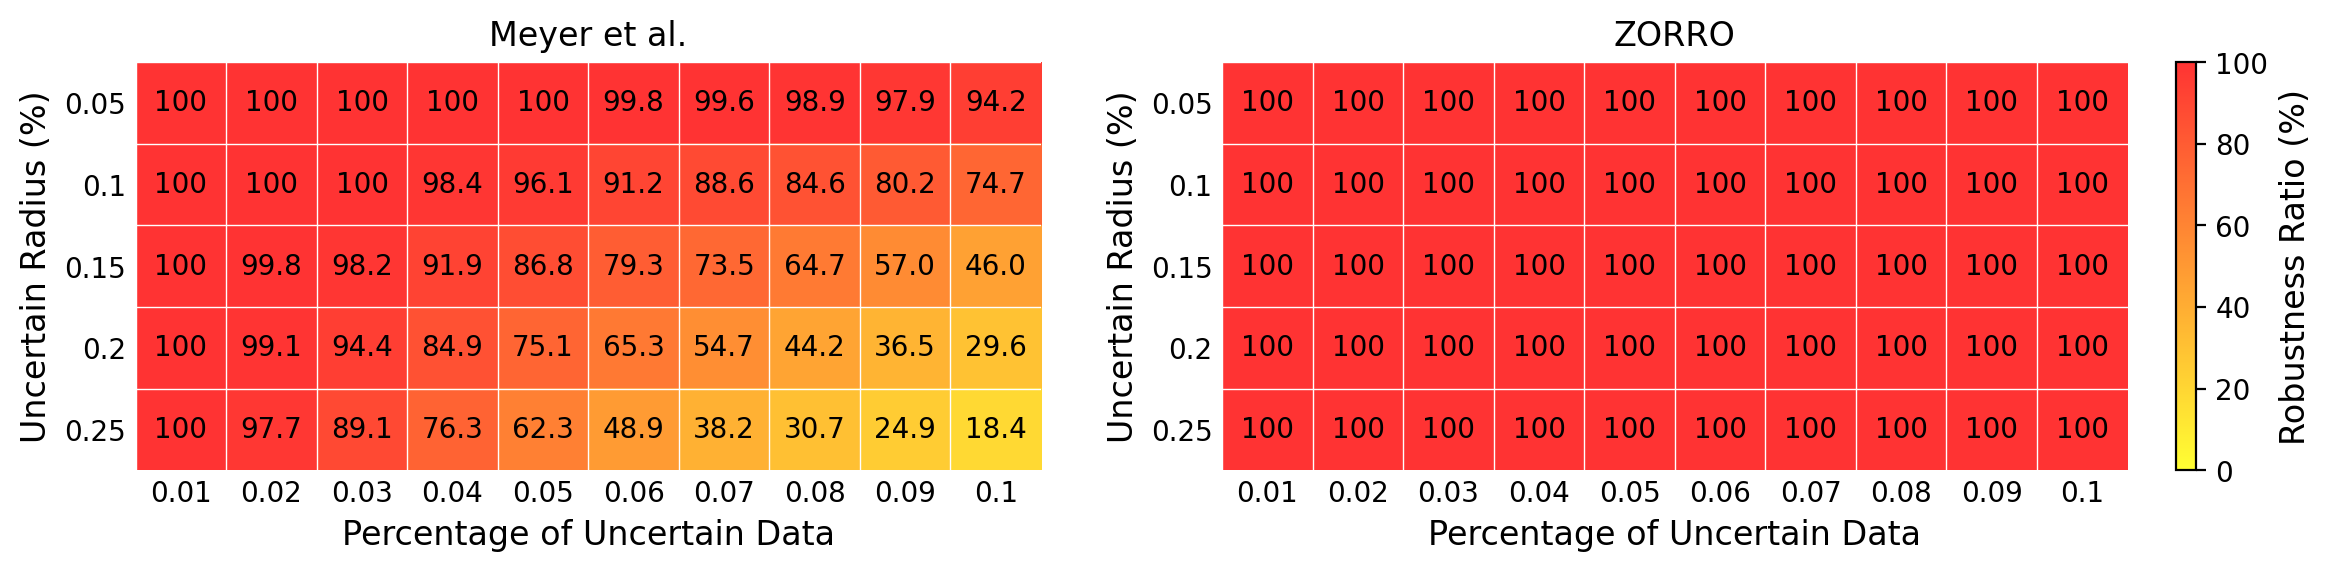

In [17]:
# Heatmaps
df = robustness_zonotope_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages

# Labels for x-axis and y-axis
x_labels = df.columns.tolist()
y_labels = [0.05, 0.10, 0.15, 0.2, 0.25]

# Create the heatmap plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True, dpi=200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), dpi=200)
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("autumn_r")
heatmap = ax1.imshow(heatmap_data, cmap=cmap, interpolation='nearest', aspect='auto', 
                     alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar = plt.colorbar(heatmap, ax=ax1)
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax1.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax1.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(x_labels)
ax1.set_yticklabels(y_labels)
ax1.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set axis labels
ax1.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax1.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.0f}', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax1.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.1f}', ha='center', va='center', color='black')
ax1.set_title('Meyer et al.')

df = robustness_interval_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages
heatmap2 = ax2.imshow(heatmap_data, cmap=cmap, interpolation='nearest', 
                      aspect='auto', alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax2.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax2.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax2.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax2.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_xticklabels(x_labels)
ax2.set_yticklabels(y_labels)
ax2.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Set axis labels
ax2.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax2.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax2.text(j, i, '100', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax2.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax2.text(j, i, f'{np.around(heatmap_data[i][j], 1)}', ha='center', 
                            va='center', color='black')
ax2.set_title('ZORRO')

# fig.suptitle('Robustness Ratio (%)', fontsize=14)
plt.subplots_adjust(wspace=0.2, bottom=0.2, left=0.1, right=0.9)
cb = fig.colorbar(heatmap2, ax=(ax1, ax2), orientation='vertical', pad=0.02)
cb.set_label('Robustness Ratio (%)', fontsize=12)
plt.savefig('wis_cancer-heatmap.pdf', bbox_inches='tight')

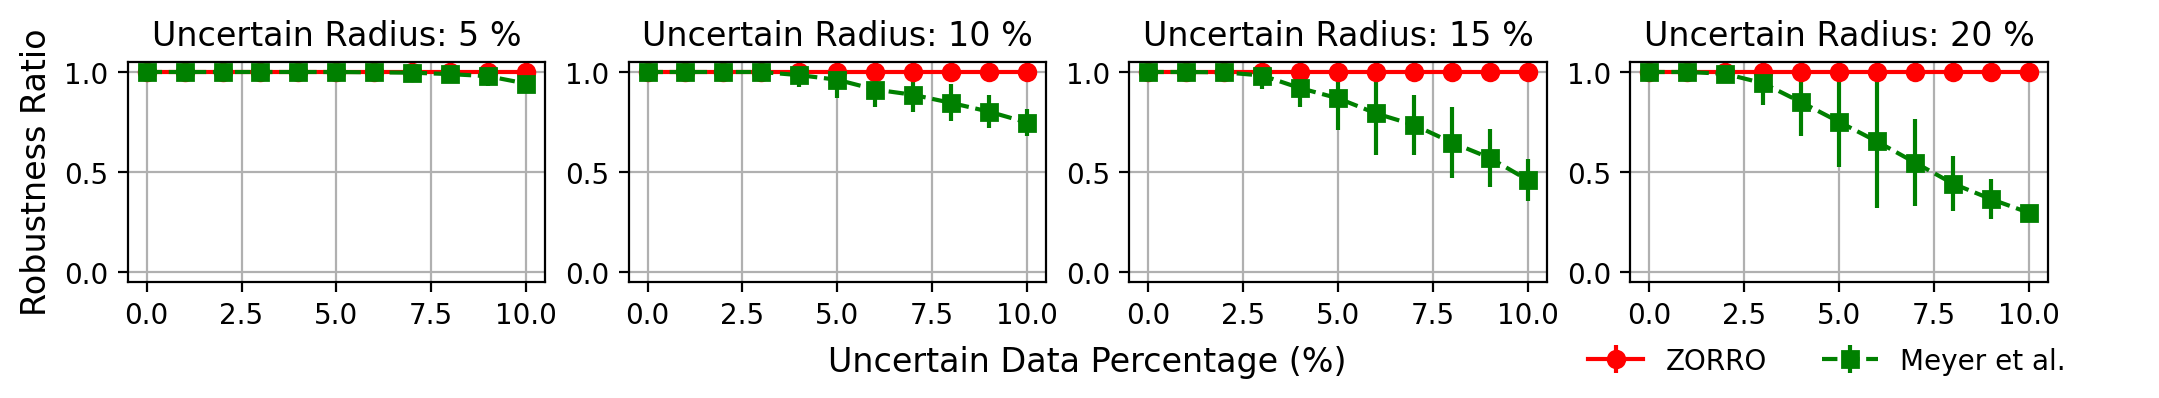

In [18]:
uncertain_pcts = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])*100
uncertain_radius_ratios = [0.05, 0.10, 0.15, 0.2, 0.25]

zonotope_data_mean_dict = dict()
zonotope_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    zonotope_data_mean_dict[radius_ratio] = np.append([1], robustness_zonotope_mean.iloc[i, :].to_numpy())
    zonotope_data_std_dict[radius_ratio] = np.append([0], robustness_zonotope_std.iloc[i, :].to_numpy())

interval_data_mean_dict = dict()
interval_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    interval_data_mean_dict[radius_ratio] = np.append([1], robustness_interval_mean.iloc[i, :].to_numpy())
    interval_data_std_dict[radius_ratio] = np.append([0], robustness_interval_std.iloc[i, :].to_numpy())
    
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)

for i in range(4):
    uncertain_radius_ratio = uncertain_radius_ratios[i]
    axes[i].errorbar(uncertain_pcts, interval_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*interval_data_std_dict[uncertain_radius_ratio],
                     marker='o', color='r', label='ZORRO', linestyle='-')
    axes[i].errorbar(uncertain_pcts, zonotope_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*zonotope_data_std_dict[uncertain_radius_ratio],
                     marker='s', color='green', label='Meyer et al.', linestyle='--')
    axes[i].set_title(f'Uncertain Radius: {int(uncertain_radius_ratio*100)} %')
    if i == 0:
        axes[i].set_ylabel('Robustness Ratio', fontsize=12)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].grid(True)

# Adjust layout
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.73, 0.03), ncol=2, frameon=False)

plt.subplots_adjust(wspace=0.2, top=0.8, bottom=0.25, left=0.1, right=0.9)
fig.supxlabel('Uncertain Data Percentage (%)', fontsize=12, verticalalignment='bottom')
# plt.tight_layout()
# plt.show()
plt.savefig('cancer-labels-lineplot.pdf', bbox_inches='tight')

In [8]:
#targeting the sensitive predictions
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

probs = log_reg.predict_proba(X_train)[:, 1]  # Probab for the positive class
boundary_indices = np.argsort(np.abs(probs - 0.5))
boundary_indices

array([ 72, 299, 120, 180, 364, 332, 395, 382, 144, 403, 147,   6, 239,
       202, 362, 335, 309, 124, 203, 136, 327, 140,  59, 130, 197,  34,
       436, 398, 354, 435, 357, 369, 204, 323, 155, 177,  55, 115,  53,
       286,  82, 402, 241, 306, 340, 283, 310,  18, 160, 441, 274, 406,
        81, 279, 451, 365, 288, 413, 281,  50, 117, 454, 129, 141, 447,
       445, 326, 260,  24,  86, 183, 328,  21, 272, 113, 269, 391, 453,
       107, 432, 446,  75,  67, 338,  10,  39,  61,   3, 119, 334,  66,
       262,  22, 290, 205, 193, 236, 127, 171, 151, 181, 393,  95, 285,
       437, 149, 380, 158, 250, 227,  20,  71, 163, 244, 121, 118,  56,
       368,  63, 169, 134, 196,  64, 296, 175, 111, 247, 251, 282,  74,
       422, 284,  31,  94, 192,  23, 409, 222,  25,  30, 242,  73,  26,
       344, 253,  51, 145, 229,  13,  93, 394, 106, 210, 257, 264, 305,
       444,  36,  77, 182, 138, 176, 170, 214,  43, 312, 297, 378,  48,
       420,  54, 265, 116, 356, 392, 431, 231, 434, 370, 216,   

In [12]:
def inject_sensitive_ranges(X, y, uncertain_attr, uncertain_num, uncertain_radius_pct=None, 
                  uncertain_radius=None, seed=42):
    global symbol_id
    symbol_id = -1
    
    X_extended = np.append(np.ones((len(X), 1)), X, axis=1)
    ss = StandardScaler()
    X_extended[:, 1:] = ss.fit_transform(X_extended[:, 1:])
    X_extended_symb = sympy.Matrix(X_extended)
    
    if not(uncertain_attr=='y'):
        uncertain_attr_idx = X.columns.to_list().index(uncertain_attr) + 1
        if not(uncertain_radius):
            uncertain_radius = uncertain_radius_pct*(np.max(X_extended[:, uncertain_attr_idx])-\
                                                     np.min(X_extended[:, uncertain_attr_idx]))
    else:
        if not(uncertain_radius):
            uncertain_radius = uncertain_radius_pct*(y_train.max()-y_train.min())[0]
    
    np.random.seed(seed)
    uncertain_indices = boundary_indices[:uncertain_num]
    y_symb = sympy.Matrix(y)
    symbols_in_data = set()
    #print(uncertain_indices)
    for uncertain_idx in uncertain_indices:
        new_symb = create_symbol()
        symbols_in_data.add(new_symb)
        if uncertain_attr=='y':
            y_symb[uncertain_idx] = y_symb[uncertain_idx] + uncertain_radius*new_symb
        else:
            X_extended_symb[uncertain_idx, uncertain_attr_idx] = X_extended_symb[uncertain_idx, uncertain_attr_idx] + uncertain_radius*new_symb
    return X_extended_symb, y_symb, symbols_in_data, ss

# if interval=True, use interval arithmetic, otherwise use zonotopes
def compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, robustness_radius,
                                         uncertain_num, uncertain_radius=None, 
                                         lr=0.1, seed=42, interval=True):
    X, y, symbols_in_data, ss = inject_sensitive_ranges(X=X_train, y=y_train, uncertain_attr='y', 
                                              uncertain_num=uncertain_num, uncertain_radius=uncertain_radius, 
                                              uncertain_radius_pct=None, seed=seed)
    
    assert len(X.free_symbols)==0
    # closed-form
    param = (X.T*X).inv()*X.T*y
    
    if interval:
        # make param intervals
        for d in range(len(param)):
            expr = param[d]
            if not(expr.free_symbols):
                continue
            else:
                constant_part = 0
                interval_radius = 0
                for arg in expr.args:
                    if arg.free_symbols:
                        interval_radius += abs(arg.args[0])
                    else:
                        assert constant_part == 0
                        constant_part = arg
                param[d] = constant_part + create_symbol()*interval_radius
    
    test_preds = sympy.Matrix(np.append(np.ones((len(X_test), 1)), ss.transform(X_test), axis=1))*param
    robustness_ls = []
    for pred in test_preds:
        pred_range_radius = 0
        for arg in pred.args:
            if arg.free_symbols:
                pred_range_radius += abs(arg.args[0])
        if pred_range_radius <= robustness_radius:
            robustness_ls.append(1)
        else:
            robustness_ls.append(0)
    
#     print(param)
    return np.mean(robustness_ls)

In [9]:
# Running results with parameter adjustments on Meyer
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num, 
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
robustness_interval_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_interval_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_interval_mean)**2 for i in range(5)])/5).apply(np.sqrt)

In [11]:
# Running results with parameter adjustments on Zonotope
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num, 
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [12]:
robustness_zonotope_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_zonotope_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_zonotope_mean)**2 for i in range(5)])/5).apply(np.sqrt)

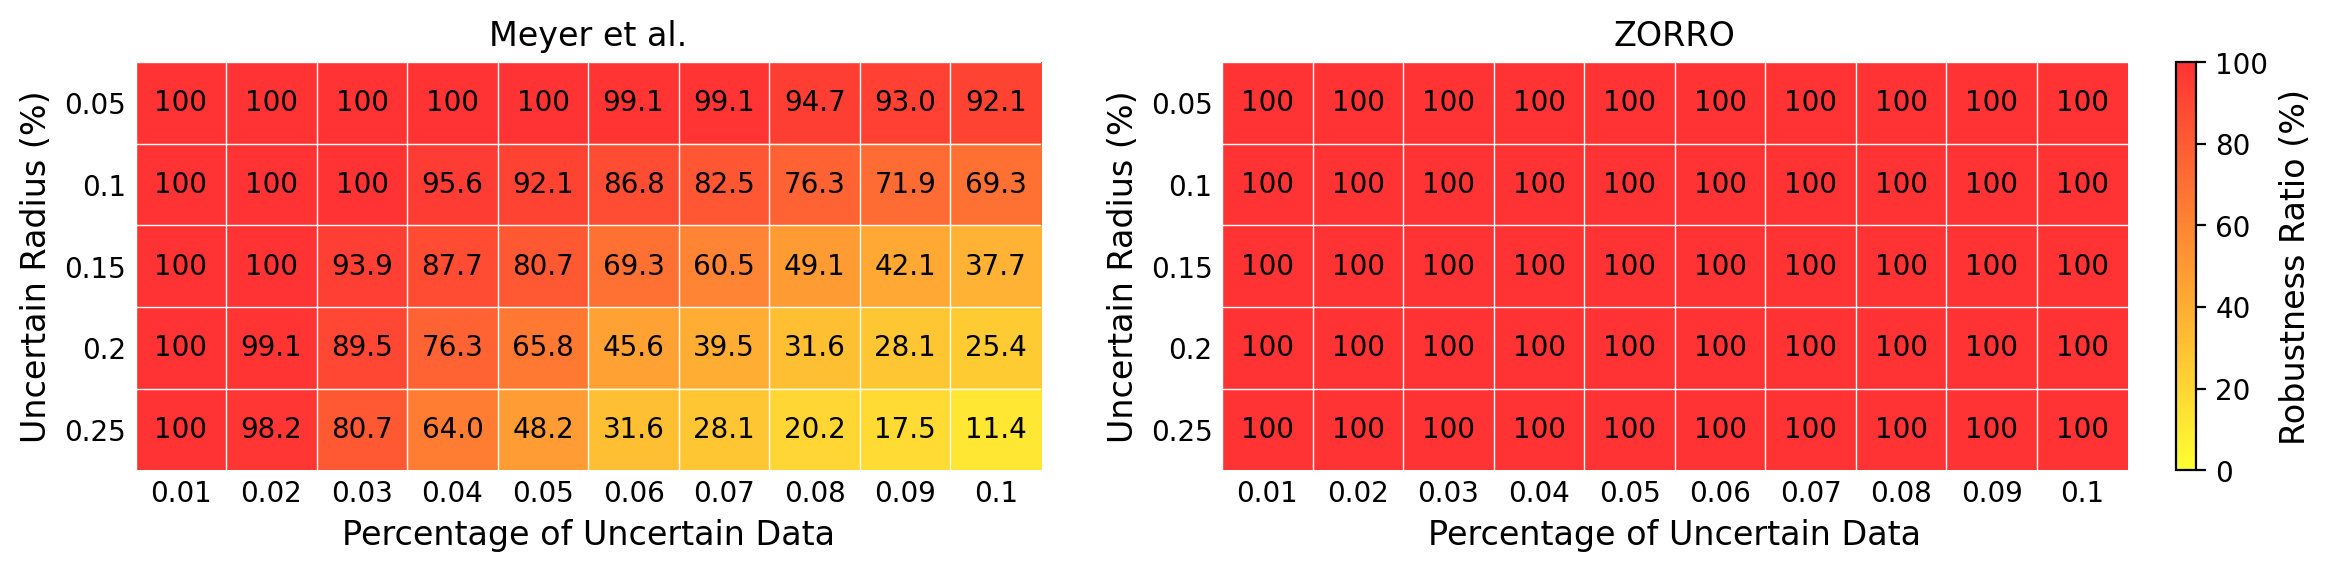

In [13]:
# Heatmaps
df = robustness_interval_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages

# Labels for x-axis and y-axis
x_labels = df.columns.tolist()
y_labels = [0.05, 0.10, 0.15, 0.2, 0.25]

# Create the heatmap plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True, dpi=200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), dpi=200)
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("autumn_r")
heatmap = ax1.imshow(heatmap_data, cmap=cmap, interpolation='nearest', aspect='auto', 
                     alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar = plt.colorbar(heatmap, ax=ax1)
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax1.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax1.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(x_labels)
ax1.set_yticklabels(y_labels)
ax1.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set axis labels
ax1.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax1.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.0f}', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax1.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.1f}', ha='center', va='center', color='black')
ax1.set_title('Meyer et al.')

df = robustness_zonotope_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages
heatmap2 = ax2.imshow(heatmap_data, cmap=cmap, interpolation='nearest', 
                      aspect='auto', alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax2.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax2.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax2.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax2.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_xticklabels(x_labels)
ax2.set_yticklabels(y_labels)
ax2.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Set axis labels
ax2.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax2.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax2.text(j, i, '100', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax2.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax2.text(j, i, f'{np.around(heatmap_data[i][j], 1)}', ha='center', 
                            va='center', color='black')
ax2.set_title('ZORRO')

# fig.suptitle('Robustness Ratio (%)', fontsize=14)
plt.subplots_adjust(wspace=0.2, bottom=0.2, left=0.1, right=0.9)
cb = fig.colorbar(heatmap2, ax=(ax1, ax2), orientation='vertical', pad=0.02)
cb.set_label('Robustness Ratio (%)', fontsize=12)
plt.savefig('sensitive_label_cancer-heatmap.pdf', bbox_inches='tight')

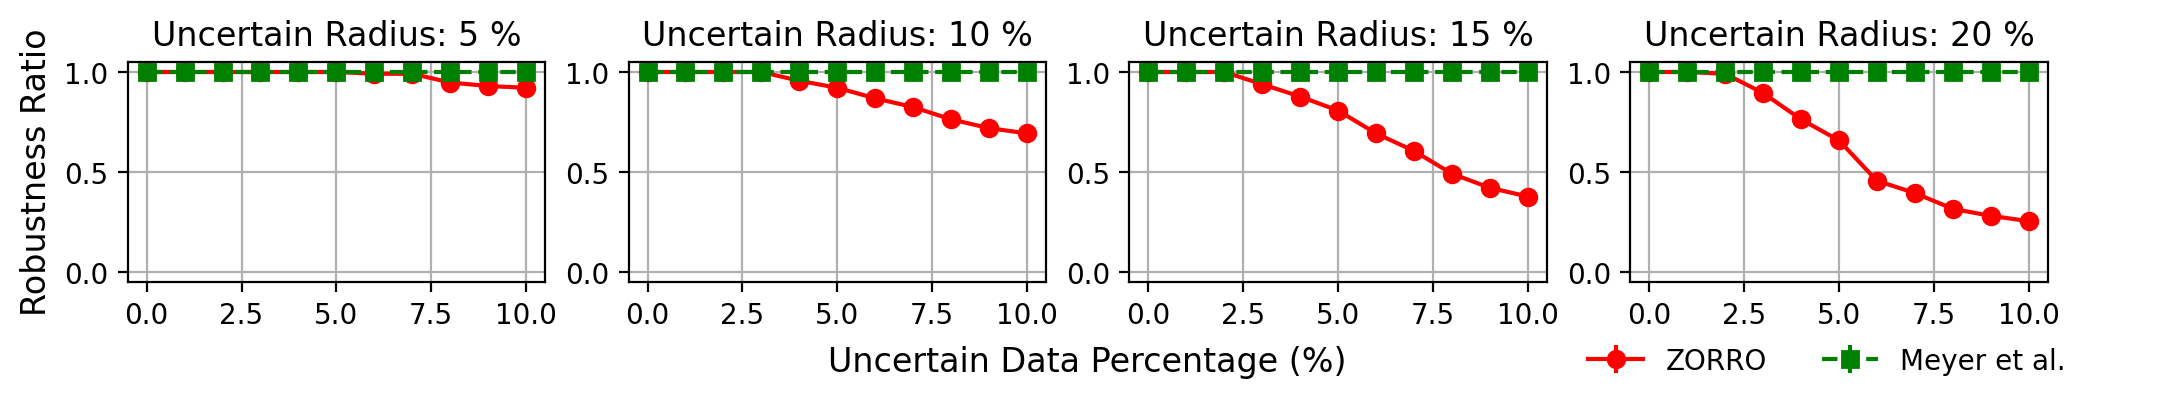

In [14]:
uncertain_pcts = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])*100
uncertain_radius_ratios = [0.05, 0.10, 0.15, 0.2, 0.25]

zonotope_data_mean_dict = dict()
zonotope_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    zonotope_data_mean_dict[radius_ratio] = np.append([1], robustness_zonotope_mean.iloc[i, :].to_numpy())
    zonotope_data_std_dict[radius_ratio] = np.append([0], robustness_zonotope_std.iloc[i, :].to_numpy())

interval_data_mean_dict = dict()
interval_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    interval_data_mean_dict[radius_ratio] = np.append([1], robustness_interval_mean.iloc[i, :].to_numpy())
    interval_data_std_dict[radius_ratio] = np.append([0], robustness_interval_std.iloc[i, :].to_numpy())
    
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)

for i in range(4):
    uncertain_radius_ratio = uncertain_radius_ratios[i]
    axes[i].errorbar(uncertain_pcts, interval_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*interval_data_std_dict[uncertain_radius_ratio],
                     marker='o', color='r', label='ZORRO', linestyle='-')
    axes[i].errorbar(uncertain_pcts, zonotope_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*zonotope_data_std_dict[uncertain_radius_ratio],
                     marker='s', color='green', label='Meyer et al.', linestyle='--')
    axes[i].set_title(f'Uncertain Radius: {int(uncertain_radius_ratio*100)} %')
    if i == 0:
        axes[i].set_ylabel('Robustness Ratio', fontsize=12)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].grid(True)

# Adjust layout
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.73, 0.03), ncol=2, frameon=False)

plt.subplots_adjust(wspace=0.2, top=0.8, bottom=0.25, left=0.1, right=0.9)
fig.supxlabel('Uncertain Data Percentage (%)', fontsize=12, verticalalignment='bottom')
# plt.tight_layout()
# plt.show()
plt.savefig('sensitive-cancer-labels-lineplot.pdf', bbox_inches='tight')

## leave_one_out set up

In [9]:
def leave_one_out(X_train, y_train, X_test, y_test, model_type, metric, maximize=True):
    predictions = model_type().fit(X_train, y_train).predict(X_test)
    initial_metric = metric(y_test.to_numpy(), predictions)
    influence_results = []
    
    for i in range(len(X_train)):
        X_train_new = np.delete(X_train, i, axis=0)
        y_train_new = np.delete(y_train, i, axis=0)
        
        new_preds = model_type().fit(X_train_new, y_train_new).predict(X_test)
        new_metric = metric(y_test.to_numpy(), new_preds)
        
        metric_diff = (initial_metric - new_metric) if maximize else (new_metric - initial_metric)
        
        influence_results.append((i, metric_diff))
        
        
    
    influence_results = sorted(influence_results,key=lambda x: x[1], reverse=True)
    #print(influence_results)
    return [i[0] for i in influence_results]

def accuracy(y_true, y_pred):
    return sum(y_true == y_pred)/len(y_true)

def precision(y_true, y_pred):
    TP = 0
    FP = 0
    for i in range(0, len(y_pred)):
        if y_pred[i] == 1:
            if y_true[i] == 1:
                TP += 1
            else:
                FP += 1
    return TP/(TP + FP)

def recall(y_true, y_pred):
    TP = 0
    FN = 0
    for i in range(0, len(y_pred)):
        if y_pred[i] == 1:
            if y_true[i] == 1:
                TP += 1
        else:
            if y_true[i] == 1:
                FN += 1
    return TP/(TP + FN)

def f2(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*prec*rec/(prec + rec)

In [11]:
#Using accuracy:
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True) , X_test.reset_index(drop=True) , y_train.reset_index(drop=True) , y_test.reset_index(drop=True)
boundary_indices = leave_one_out(X_train, y_train, X_test, y_test, LogisticRegression, accuracy)
boundary_indices 

In [ ]:
# Running results with parameter adjustments on Meyer
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num, 
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

In [ ]:
robustness_interval_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_interval_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_interval_mean)**2 for i in range(5)])/5).apply(np.sqrt)

In [ ]:
# Running results with parameter adjustments on Zonotope
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num, 
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

In [15]:
robustness_zonotope_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_zonotope_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_zonotope_mean)**2 for i in range(5)])/5).apply(np.sqrt)

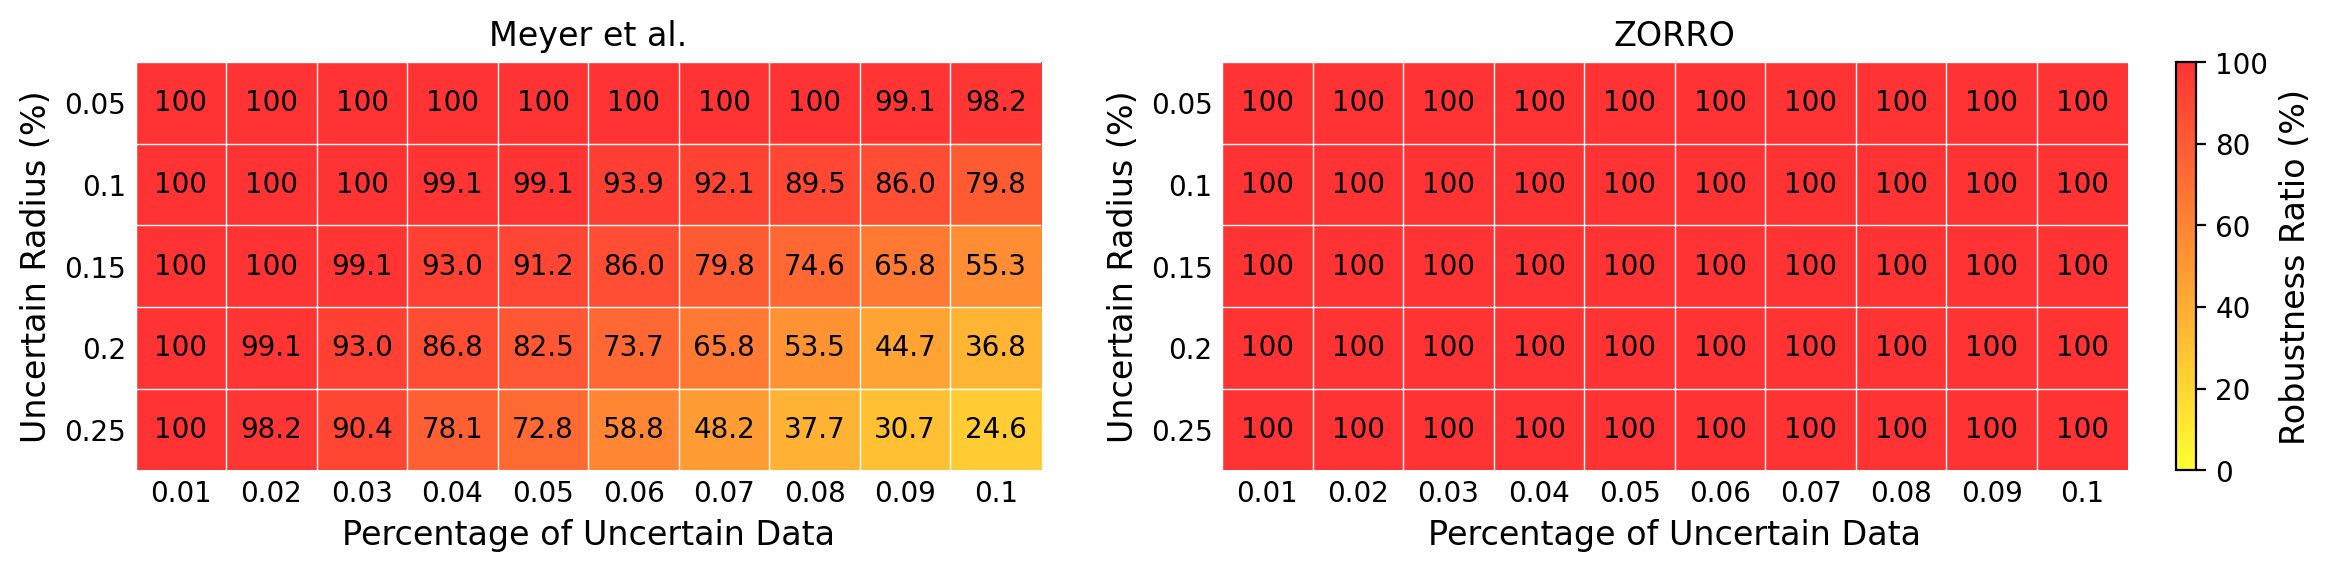

In [16]:
# Heatmaps
df = robustness_interval_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages

# Labels for x-axis and y-axis
x_labels = df.columns.tolist()
y_labels = [0.05, 0.10, 0.15, 0.2, 0.25]

# Create the heatmap plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True, dpi=200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), dpi=200)
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("autumn_r")
heatmap = ax1.imshow(heatmap_data, cmap=cmap, interpolation='nearest', aspect='auto', 
                     alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar = plt.colorbar(heatmap, ax=ax1)
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax1.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax1.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(x_labels)
ax1.set_yticklabels(y_labels)
ax1.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set axis labels
ax1.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax1.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.0f}', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax1.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.1f}', ha='center', va='center', color='black')
ax1.set_title('Meyer et al.')

df = robustness_zonotope_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages
heatmap2 = ax2.imshow(heatmap_data, cmap=cmap, interpolation='nearest', 
                      aspect='auto', alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax2.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax2.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax2.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax2.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_xticklabels(x_labels)
ax2.set_yticklabels(y_labels)
ax2.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Set axis labels
ax2.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax2.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax2.text(j, i, '100', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax2.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax2.text(j, i, f'{np.around(heatmap_data[i][j], 1)}', ha='center', 
                            va='center', color='black')
ax2.set_title('ZORRO')

# fig.suptitle('Robustness Ratio (%)', fontsize=14)
plt.subplots_adjust(wspace=0.2, bottom=0.2, left=0.1, right=0.9)
cb = fig.colorbar(heatmap2, ax=(ax1, ax2), orientation='vertical', pad=0.02)
cb.set_label('Robustness Ratio (%)', fontsize=12)
plt.savefig('acc-sensitive_label_cancer-heatmap.pdf', bbox_inches='tight')

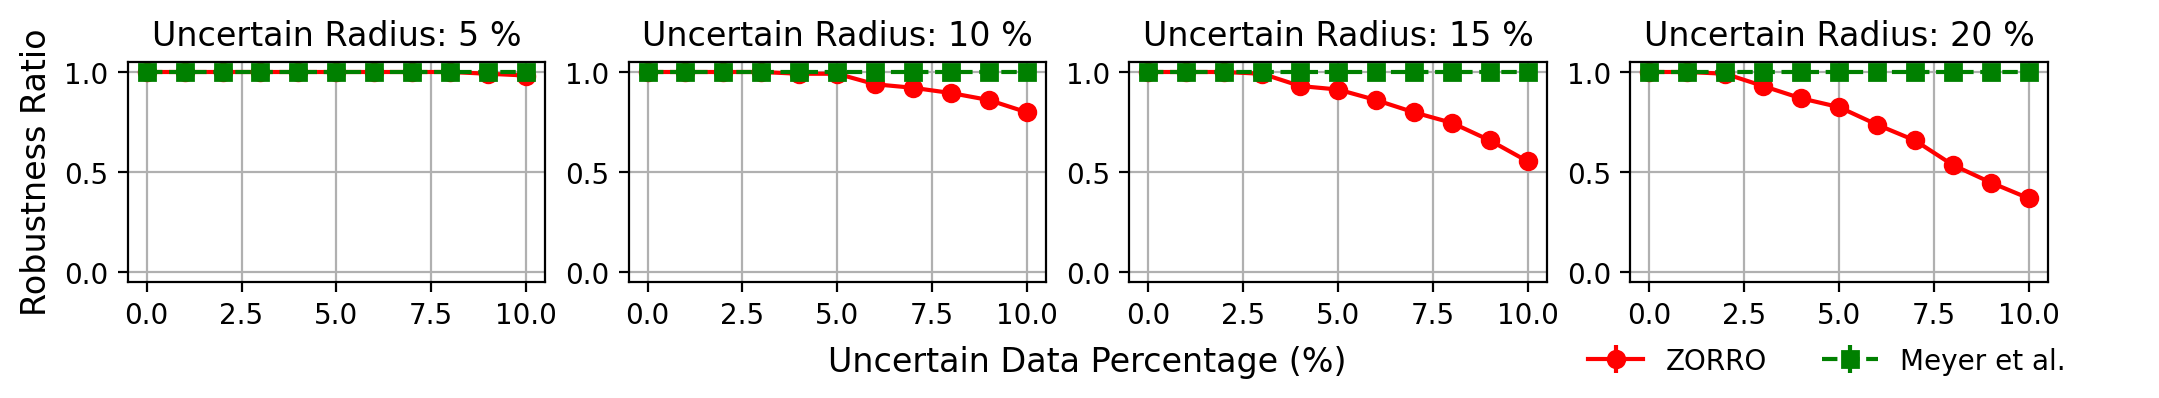

In [17]:
uncertain_pcts = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])*100
uncertain_radius_ratios = [0.05, 0.10, 0.15, 0.2, 0.25]

zonotope_data_mean_dict = dict()
zonotope_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    zonotope_data_mean_dict[radius_ratio] = np.append([1], robustness_zonotope_mean.iloc[i, :].to_numpy())
    zonotope_data_std_dict[radius_ratio] = np.append([0], robustness_zonotope_std.iloc[i, :].to_numpy())

interval_data_mean_dict = dict()
interval_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    interval_data_mean_dict[radius_ratio] = np.append([1], robustness_interval_mean.iloc[i, :].to_numpy())
    interval_data_std_dict[radius_ratio] = np.append([0], robustness_interval_std.iloc[i, :].to_numpy())
    
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)

for i in range(4):
    uncertain_radius_ratio = uncertain_radius_ratios[i]
    axes[i].errorbar(uncertain_pcts, interval_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*interval_data_std_dict[uncertain_radius_ratio],
                     marker='o', color='r', label='ZORRO', linestyle='-')
    axes[i].errorbar(uncertain_pcts, zonotope_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*zonotope_data_std_dict[uncertain_radius_ratio],
                     marker='s', color='green', label='Meyer et al.', linestyle='--')
    axes[i].set_title(f'Uncertain Radius: {int(uncertain_radius_ratio*100)} %')
    if i == 0:
        axes[i].set_ylabel('Robustness Ratio', fontsize=12)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].grid(True)

# Adjust layout
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.73, 0.03), ncol=2, frameon=False)

plt.subplots_adjust(wspace=0.2, top=0.8, bottom=0.25, left=0.1, right=0.9)
fig.supxlabel('Uncertain Data Percentage (%)', fontsize=12, verticalalignment='bottom')
# plt.tight_layout()
# plt.show()
plt.savefig('acc-sensitive-cancer-labels-lineplot.pdf', bbox_inches='tight')

In [12]:
#Using precision:
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True) , X_test.reset_index(drop=True) , y_train.reset_index(drop=True) , y_test.reset_index(drop=True)
boundary_indices = leave_one_out(X_train, y_train, X_test, y_test, LogisticRegression, precision)
boundary_indices 

In [13]:
# Running results with parameter adjustments on Meyer
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num, 
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [14]:
robustness_interval_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_interval_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_interval_mean)**2 for i in range(5)])/5).apply(np.sqrt)

In [15]:
# Running results with parameter adjustments on Zonotope
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num, 
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [16]:
robustness_zonotope_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_zonotope_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_zonotope_mean)**2 for i in range(5)])/5).apply(np.sqrt)

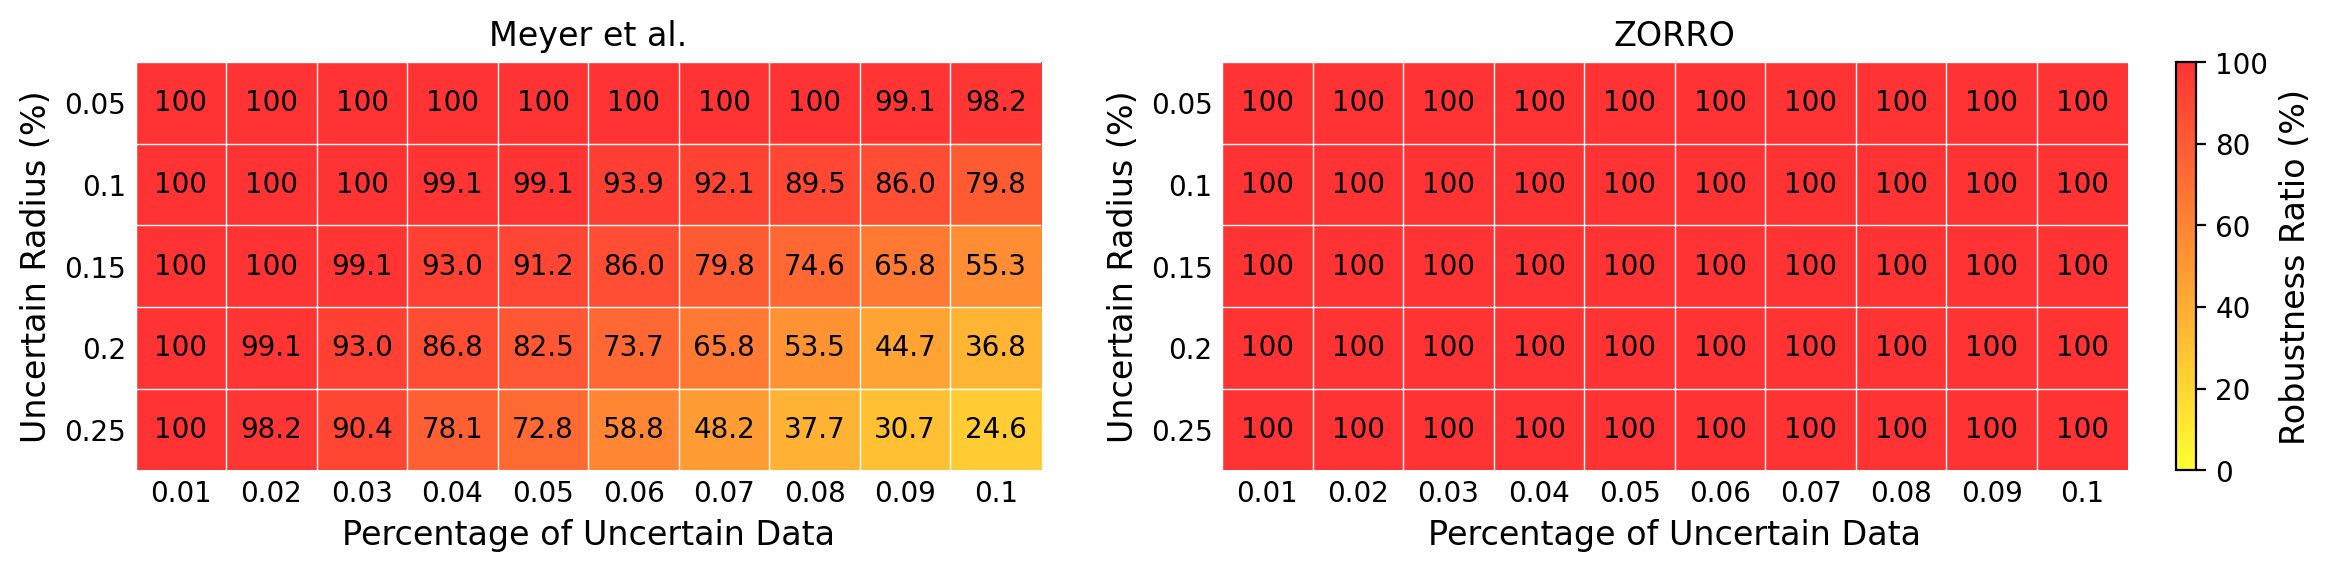

In [17]:
# Heatmaps
df = robustness_interval_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages

# Labels for x-axis and y-axis
x_labels = df.columns.tolist()
y_labels = [0.05, 0.10, 0.15, 0.2, 0.25]

# Create the heatmap plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True, dpi=200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), dpi=200)
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("autumn_r")
heatmap = ax1.imshow(heatmap_data, cmap=cmap, interpolation='nearest', aspect='auto', 
                     alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar = plt.colorbar(heatmap, ax=ax1)
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax1.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax1.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(x_labels)
ax1.set_yticklabels(y_labels)
ax1.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set axis labels
ax1.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax1.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.0f}', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax1.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.1f}', ha='center', va='center', color='black')
ax1.set_title('Meyer et al.')

df = robustness_zonotope_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages
heatmap2 = ax2.imshow(heatmap_data, cmap=cmap, interpolation='nearest', 
                      aspect='auto', alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax2.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax2.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax2.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax2.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_xticklabels(x_labels)
ax2.set_yticklabels(y_labels)
ax2.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Set axis labels
ax2.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax2.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax2.text(j, i, '100', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax2.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax2.text(j, i, f'{np.around(heatmap_data[i][j], 1)}', ha='center', 
                            va='center', color='black')
ax2.set_title('ZORRO')

# fig.suptitle('Robustness Ratio (%)', fontsize=14)
plt.subplots_adjust(wspace=0.2, bottom=0.2, left=0.1, right=0.9)
cb = fig.colorbar(heatmap2, ax=(ax1, ax2), orientation='vertical', pad=0.02)
cb.set_label('Robustness Ratio (%)', fontsize=12)
plt.savefig('prec_sensitive_label_cancer-heatmap.pdf', bbox_inches='tight')

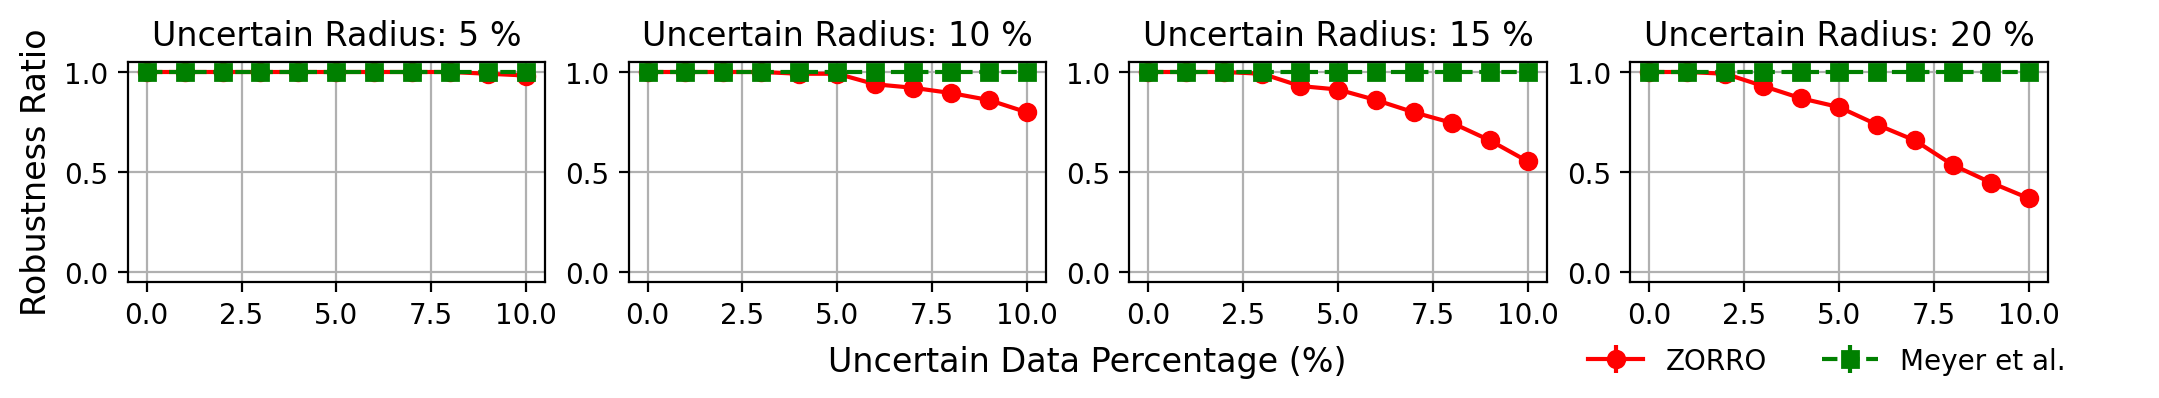

In [18]:
uncertain_pcts = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])*100
uncertain_radius_ratios = [0.05, 0.10, 0.15, 0.2, 0.25]

zonotope_data_mean_dict = dict()
zonotope_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    zonotope_data_mean_dict[radius_ratio] = np.append([1], robustness_zonotope_mean.iloc[i, :].to_numpy())
    zonotope_data_std_dict[radius_ratio] = np.append([0], robustness_zonotope_std.iloc[i, :].to_numpy())

interval_data_mean_dict = dict()
interval_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    interval_data_mean_dict[radius_ratio] = np.append([1], robustness_interval_mean.iloc[i, :].to_numpy())
    interval_data_std_dict[radius_ratio] = np.append([0], robustness_interval_std.iloc[i, :].to_numpy())
    
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)

for i in range(4):
    uncertain_radius_ratio = uncertain_radius_ratios[i]
    axes[i].errorbar(uncertain_pcts, interval_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*interval_data_std_dict[uncertain_radius_ratio],
                     marker='o', color='r', label='ZORRO', linestyle='-')
    axes[i].errorbar(uncertain_pcts, zonotope_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*zonotope_data_std_dict[uncertain_radius_ratio],
                     marker='s', color='green', label='Meyer et al.', linestyle='--')
    axes[i].set_title(f'Uncertain Radius: {int(uncertain_radius_ratio*100)} %')
    if i == 0:
        axes[i].set_ylabel('Robustness Ratio', fontsize=12)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].grid(True)

# Adjust layout
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.73, 0.03), ncol=2, frameon=False)

plt.subplots_adjust(wspace=0.2, top=0.8, bottom=0.25, left=0.1, right=0.9)
fig.supxlabel('Uncertain Data Percentage (%)', fontsize=12, verticalalignment='bottom')
# plt.tight_layout()
# plt.show()
plt.savefig('prec-sensitive-cancer-labels-lineplot.pdf', bbox_inches='tight')

In [10]:
#Using recall:
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True) , X_test.reset_index(drop=True) , y_train.reset_index(drop=True) , y_test.reset_index(drop=True)
boundary_indices = leave_one_out(X_train, y_train, X_test, y_test, LogisticRegression, recall)
boundary_indices

In [11]:
# Running results with parameter adjustments on Meyer
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num, 
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [12]:
robustness_interval_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_interval_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_interval_mean)**2 for i in range(5)])/5).apply(np.sqrt)

In [13]:
# Running results with parameter adjustments on Zonotope
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num, 
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [14]:
robustness_zonotope_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_zonotope_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_zonotope_mean)**2 for i in range(5)])/5).apply(np.sqrt)

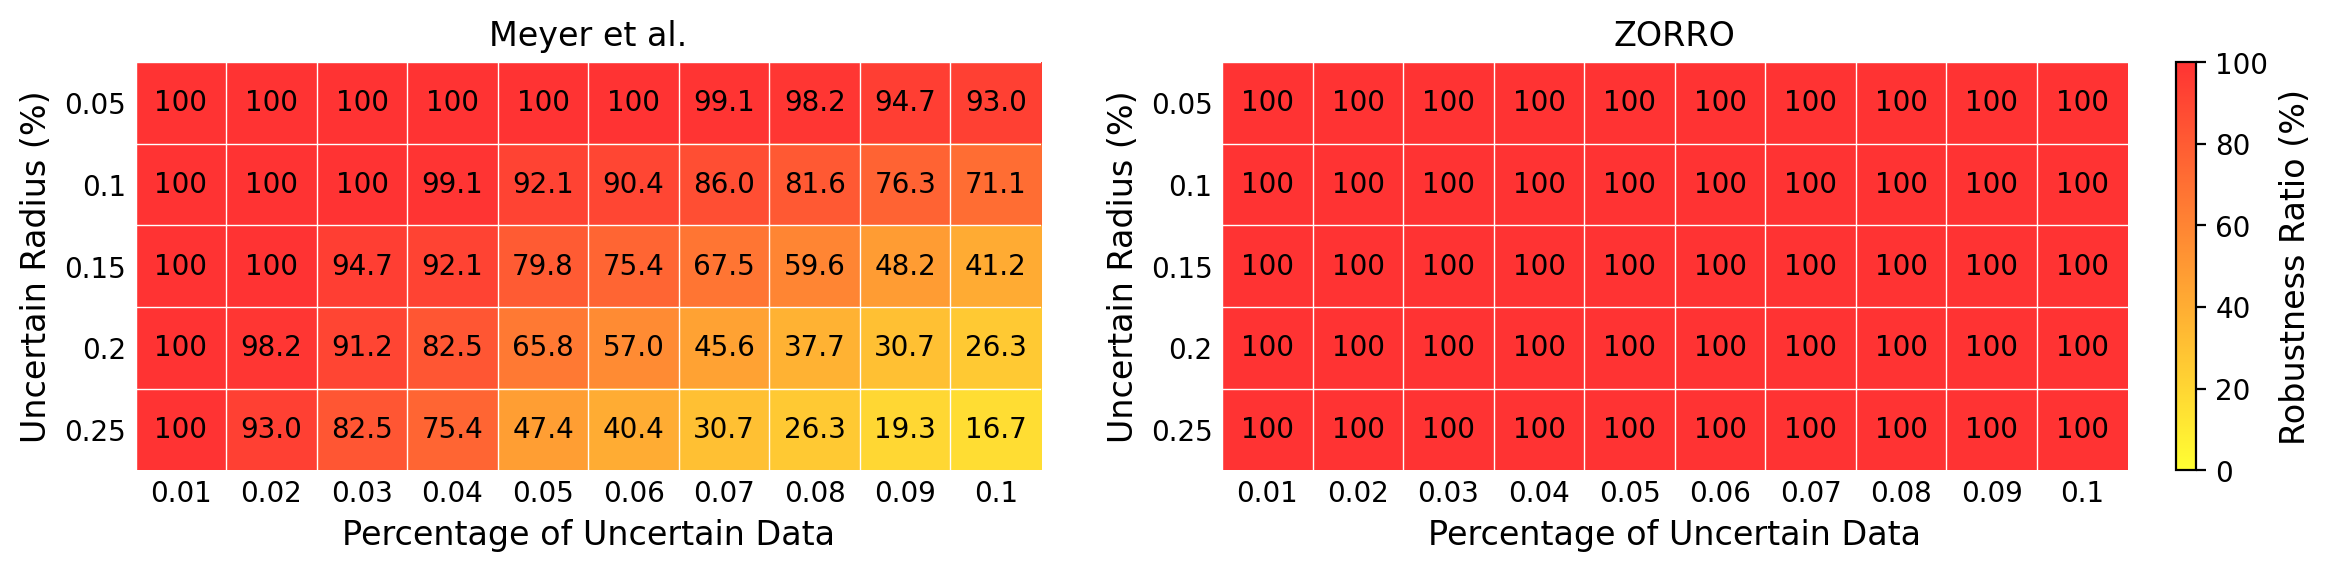

In [15]:
# Heatmaps
df = robustness_interval_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages

# Labels for x-axis and y-axis
x_labels = df.columns.tolist()
y_labels = [0.05, 0.10, 0.15, 0.2, 0.25]

# Create the heatmap plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True, dpi=200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), dpi=200)
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("autumn_r")
heatmap = ax1.imshow(heatmap_data, cmap=cmap, interpolation='nearest', aspect='auto', 
                     alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar = plt.colorbar(heatmap, ax=ax1)
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax1.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax1.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(x_labels)
ax1.set_yticklabels(y_labels)
ax1.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set axis labels
ax1.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax1.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.0f}', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax1.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.1f}', ha='center', va='center', color='black')
ax1.set_title('Meyer et al.')

df = robustness_zonotope_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages
heatmap2 = ax2.imshow(heatmap_data, cmap=cmap, interpolation='nearest', 
                      aspect='auto', alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax2.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax2.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax2.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax2.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_xticklabels(x_labels)
ax2.set_yticklabels(y_labels)
ax2.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Set axis labels
ax2.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax2.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax2.text(j, i, '100', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax2.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax2.text(j, i, f'{np.around(heatmap_data[i][j], 1)}', ha='center', 
                            va='center', color='black')
ax2.set_title('ZORRO')

# fig.suptitle('Robustness Ratio (%)', fontsize=14)
plt.subplots_adjust(wspace=0.2, bottom=0.2, left=0.1, right=0.9)
cb = fig.colorbar(heatmap2, ax=(ax1, ax2), orientation='vertical', pad=0.02)
cb.set_label('Robustness Ratio (%)', fontsize=12)
plt.savefig('recall_sensitive_label_cancer-heatmap.pdf', bbox_inches='tight')

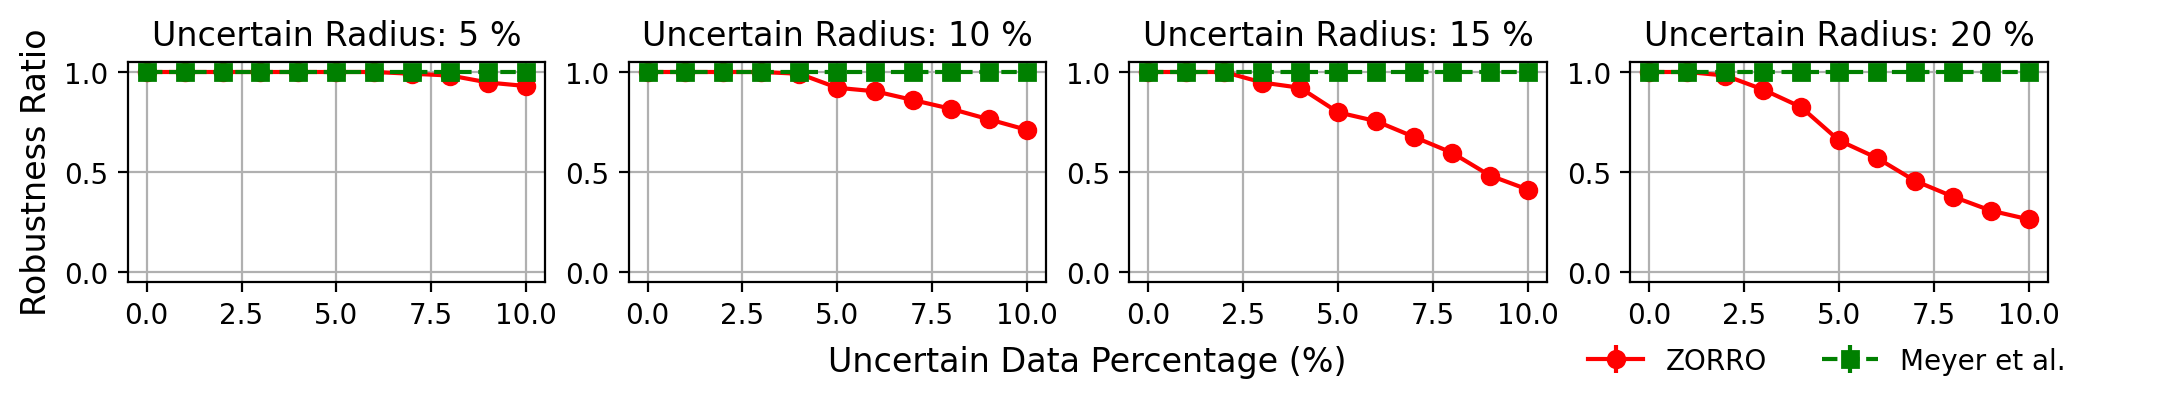

In [16]:
uncertain_pcts = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])*100
uncertain_radius_ratios = [0.05, 0.10, 0.15, 0.2, 0.25]

zonotope_data_mean_dict = dict()
zonotope_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    zonotope_data_mean_dict[radius_ratio] = np.append([1], robustness_zonotope_mean.iloc[i, :].to_numpy())
    zonotope_data_std_dict[radius_ratio] = np.append([0], robustness_zonotope_std.iloc[i, :].to_numpy())

interval_data_mean_dict = dict()
interval_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    interval_data_mean_dict[radius_ratio] = np.append([1], robustness_interval_mean.iloc[i, :].to_numpy())
    interval_data_std_dict[radius_ratio] = np.append([0], robustness_interval_std.iloc[i, :].to_numpy())
    
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)

for i in range(4):
    uncertain_radius_ratio = uncertain_radius_ratios[i]
    axes[i].errorbar(uncertain_pcts, interval_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*interval_data_std_dict[uncertain_radius_ratio],
                     marker='o', color='r', label='ZORRO', linestyle='-')
    axes[i].errorbar(uncertain_pcts, zonotope_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*zonotope_data_std_dict[uncertain_radius_ratio],
                     marker='s', color='green', label='Meyer et al.', linestyle='--')
    axes[i].set_title(f'Uncertain Radius: {int(uncertain_radius_ratio*100)} %')
    if i == 0:
        axes[i].set_ylabel('Robustness Ratio', fontsize=12)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].grid(True)

# Adjust layout
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.73, 0.03), ncol=2, frameon=False)

plt.subplots_adjust(wspace=0.2, top=0.8, bottom=0.25, left=0.1, right=0.9)
fig.supxlabel('Uncertain Data Percentage (%)', fontsize=12, verticalalignment='bottom')
# plt.tight_layout()
# plt.show()
plt.savefig('recall_sensitive-cancer-labels-lineplot.pdf', bbox_inches='tight')

In [10]:
#Using f2:
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True) , X_test.reset_index(drop=True) , y_train.reset_index(drop=True) , y_test.reset_index(drop=True)
boundary_indices = leave_one_out(X_train, y_train, X_test, y_test, LogisticRegression, f2)
boundary_indices

In [13]:
# Running results with parameter adjustments on Meyer
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num, 
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [14]:
robustness_interval_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_interval_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_interval_mean)**2 for i in range(5)])/5).apply(np.sqrt)

In [15]:
# Running results with parameter adjustments on Zonotope
robustness_dicts = []
for seed in range(5):
    # mpg +- 2 is robust
    robustness_radius = 2
    label_range = (y_train.max()-y_train.min())
    ratios = [0.05, 0.10, 0.15, 0.2, 0.25]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc='Progess'):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius'):
            #print(uncertain_radius)
            robustness_ratio = compute_robustness_ratio_sensitive_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num, 
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Progess:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/5 [00:00<?, ?it/s]

In [16]:
robustness_zonotope_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_zonotope_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_zonotope_mean)**2 for i in range(5)])/5).apply(np.sqrt)

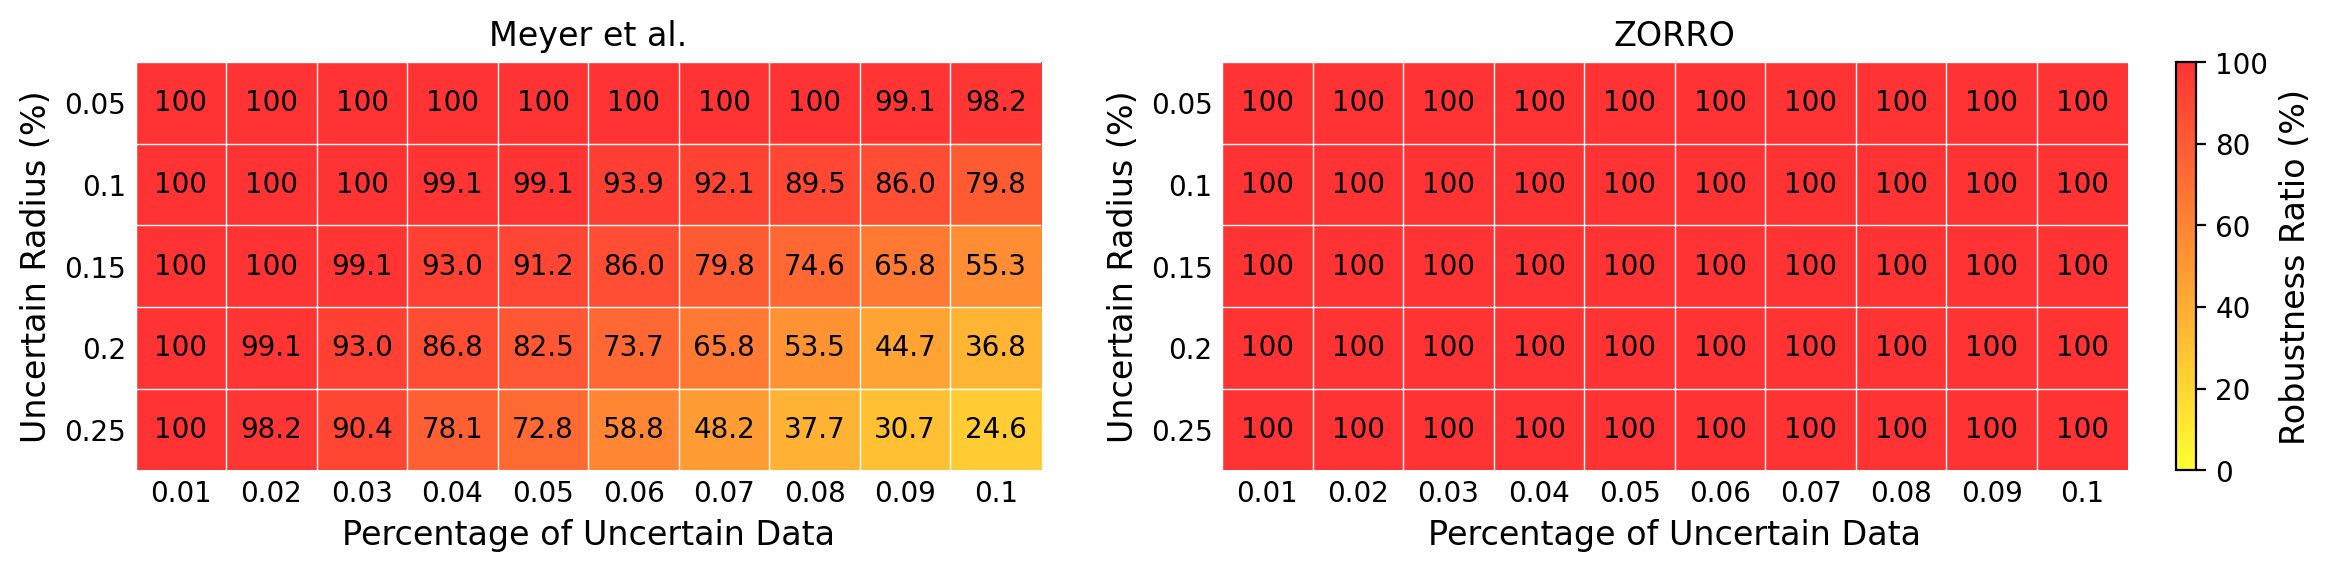

In [17]:
# Heatmaps
df = robustness_interval_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages

# Labels for x-axis and y-axis
x_labels = df.columns.tolist()
y_labels = [0.05, 0.10, 0.15, 0.2, 0.25]

# Create the heatmap plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True, dpi=200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), dpi=200)
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("autumn_r")
heatmap = ax1.imshow(heatmap_data, cmap=cmap, interpolation='nearest', aspect='auto', 
                     alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar = plt.colorbar(heatmap, ax=ax1)
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax1.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax1.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(x_labels)
ax1.set_yticklabels(y_labels)
ax1.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set axis labels
ax1.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax1.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.0f}', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax1.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.1f}', ha='center', va='center', color='black')
ax1.set_title('Meyer et al.')

df = robustness_zonotope_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages
heatmap2 = ax2.imshow(heatmap_data, cmap=cmap, interpolation='nearest', 
                      aspect='auto', alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax2.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax2.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax2.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax2.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_xticklabels(x_labels)
ax2.set_yticklabels(y_labels)
ax2.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Set axis labels
ax2.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax2.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax2.text(j, i, '100', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax2.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax2.text(j, i, f'{np.around(heatmap_data[i][j], 1)}', ha='center', 
                            va='center', color='black')
ax2.set_title('ZORRO')

# fig.suptitle('Robustness Ratio (%)', fontsize=14)
plt.subplots_adjust(wspace=0.2, bottom=0.2, left=0.1, right=0.9)
cb = fig.colorbar(heatmap2, ax=(ax1, ax2), orientation='vertical', pad=0.02)
cb.set_label('Robustness Ratio (%)', fontsize=12)
plt.savefig('f2_sensitive_label_cancer-heatmap.pdf', bbox_inches='tight')

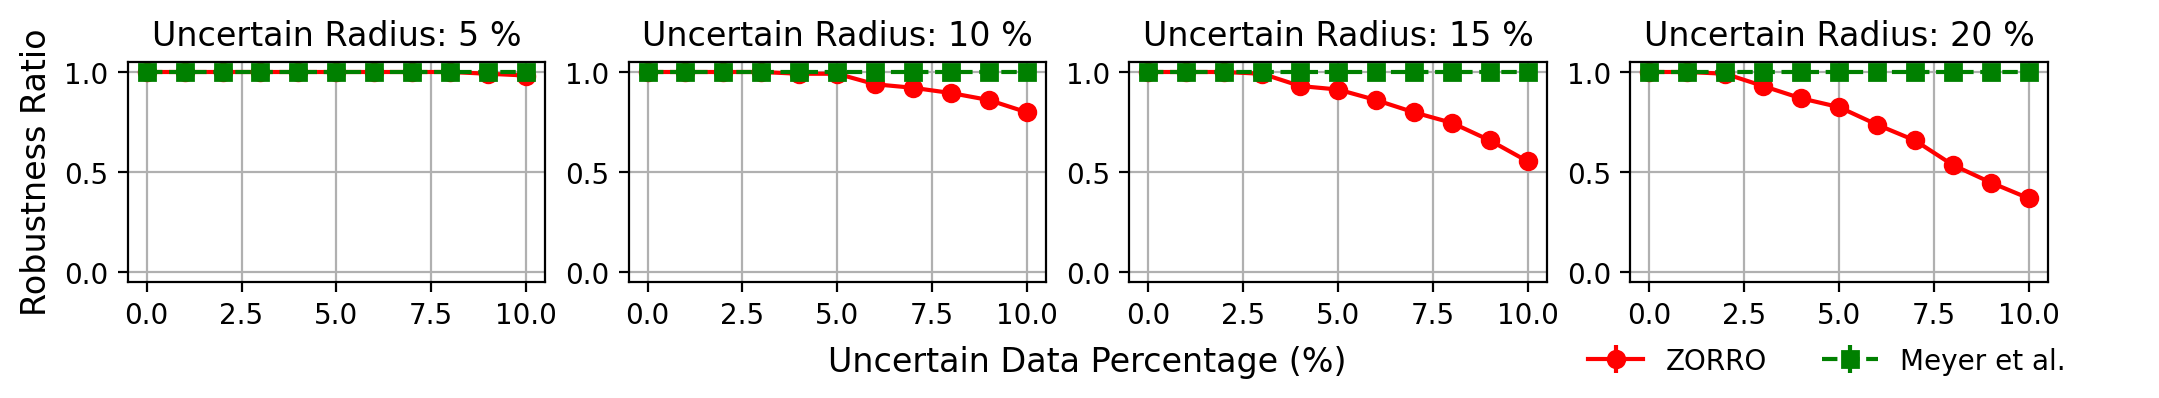

In [18]:
uncertain_pcts = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])*100
uncertain_radius_ratios = [0.05, 0.10, 0.15, 0.2, 0.25]

zonotope_data_mean_dict = dict()
zonotope_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    zonotope_data_mean_dict[radius_ratio] = np.append([1], robustness_zonotope_mean.iloc[i, :].to_numpy())
    zonotope_data_std_dict[radius_ratio] = np.append([0], robustness_zonotope_std.iloc[i, :].to_numpy())

interval_data_mean_dict = dict()
interval_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    interval_data_mean_dict[radius_ratio] = np.append([1], robustness_interval_mean.iloc[i, :].to_numpy())
    interval_data_std_dict[radius_ratio] = np.append([0], robustness_interval_std.iloc[i, :].to_numpy())
    
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)

for i in range(4):
    uncertain_radius_ratio = uncertain_radius_ratios[i]
    axes[i].errorbar(uncertain_pcts, interval_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*interval_data_std_dict[uncertain_radius_ratio],
                     marker='o', color='r', label='ZORRO', linestyle='-')
    axes[i].errorbar(uncertain_pcts, zonotope_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*zonotope_data_std_dict[uncertain_radius_ratio],
                     marker='s', color='green', label='Meyer et al.', linestyle='--')
    axes[i].set_title(f'Uncertain Radius: {int(uncertain_radius_ratio*100)} %')
    if i == 0:
        axes[i].set_ylabel('Robustness Ratio', fontsize=12)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].grid(True)

# Adjust layout
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.73, 0.03), ncol=2, frameon=False)

plt.subplots_adjust(wspace=0.2, top=0.8, bottom=0.25, left=0.1, right=0.9)
fig.supxlabel('Uncertain Data Percentage (%)', fontsize=12, verticalalignment='bottom')
# plt.tight_layout()
# plt.show()
plt.savefig('f2-sensitive-cancer-labels-lineplot.pdf', bbox_inches='tight')